## Gradient Boosting: Градиентный бустинг над решающими деревьями

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier

In [2]:
def write_answer(filename, answer):
    
    with open(filename, 'w') as fout:
        
        fout.write(str(answer))
        fout.close()

### Введение

Построение композиции — важный подход в машинном обучении, который позволяет объединять большое количество слабых алгоритмов в один сильный. Данный подход широко используется на практике в самых разных задачах.

На лекциях был рассмотрен метод градиентного бустинга, который последовательно строит композицию алгоритмов, причем каждый следующий алгоритм выбирается так, чтобы исправлять ошибки уже имеющейся композиции. Обычно в качестве базовых алгоритмов используют деревья небольшой глубины, поскольку их достаточно легко строить, и при этом они дают нелинейные разделяющие поверхности.

Другой метод построения композиций — случайный лес. В нем, в отличие от градиентного бустинга, отдельные деревья строятся независимо и без каких-либо ограничений на глубину — дерево наращивается до тех пор, пока не покажет наилучшее качество на обучающей выборке.

В этом задании мы будем иметь дело с задачей классификации. В качестве функции потерь будем использовать log-loss:

$$ L(y,z) = -y logz - (1-y) log(1-z)$$

Здесь через y обозначен истинный ответ, через z — прогноз алгоритма. Данная функция является дифференцируемой, и поэтому подходит для использования в градиентном бустинге. Также можно показать, что при ее использовании итоговый алгоритм будет приближать истинные вероятности классов.

### Данные

В рамках данного задания мы рассмотрим датасет с конкурса [Predicting a Biological Response](https://www.kaggle.com/c/bioresponse).

### Реализация в sklearn

В пакете scikit-learn градиентный бустинг реализован в модуле ensemble в виде классов <code>GradientBoostingClassifier</code> и <code>GradientBoostingRegressor</code>. Основные параметры, которые будут интересовать нас: n_estimators, learning_rate. Иногда может быть полезен параметр verbose для отслеживания процесса обучения.

Чтобы была возможность оценить качество построенной композиции на каждой итерации, у класса есть метод staged_decision_function. Для заданной выборки он возвращает ответ на каждой итерации.

Помимо алгоритмов машинного обучения, в пакете scikit-learn представлено большое число различных инструментов. В этом задании будет предложено воспользоваться функцией <code>train_test_split</code> модуля cross_validation. С помощью нее можно разбивать выборки случайным образом. На вход можно передать несколько выборок (с условием, что они имеют одинаковое количество строк). Пусть, например, имеются данные X и y, где X — это признаковое описание объектов, y — целевое значение. Тогда следующий код будет удобен для разбиения этих данных на обучающее и тестовое множества:

```python
X_train, X_test, y_train, y_test = 
                     train_test_split(X, y, 
                                      test_size=0.33, 
                                      random_state=42)
```

Обратите внимание, что при фиксированном параметре random_state результат разбиения можно воспроизвести.

Метрика log-loss реализована в пакете metrics: <code>sklearn.metrics.log_loss</code>. Заметим, что данная метрика предназначена для классификаторов, выдающих оценку принадлежности классу, а не бинарные ответы. И градиентный бустинг, и случайный лес умеют строить такие прогнозы — для этого нужно использовать метод predict_proba:

```python
pred = clf.predict_proba(X_test)
```

Метод predict_proba возвращает матрицу, i-й столбец которой содержит оценки принадлежности i-му классу. 

Для рисования кривых качества на обучении и контроле можно воспользоваться следующим кодом:
```python
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure()
plt.plot(test_loss, 'r', linewidth=2)
plt.plot(train_loss, 'g', linewidth=2)
plt.legend(['test', 'train'])
```

#### 1. Загрузите выборку из файла gbm-data.csv с помощью pandas и преобразуйте ее в массив numpy (параметр values у датафрейма). В первой колонке файла с данными записано, была или нет реакция. Все остальные колонки (d1 - d1776) содержат различные характеристики молекулы, такие как размер, форма и т.д. Разбейте выборку на обучающую и тестовую, используя функцию train_test_split с параметрами test_size = 0.8 и random_state = 241. 

In [3]:
data = pd.read_csv('gbm-data.csv')
data.head()

,Activity,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,D1767,D1768,D1769,D1770,D1771,D1772,D1773,D1774,D1775,D1776
0,1,0.000000,0.497009,0.10,0.0,0.132956,0.678031,0.273166,0.585445,0.743663,...,0,0,0,0,0,0,0,0,0,0
1,1,0.366667,0.606291,0.05,0.0,0.111209,0.803455,0.106105,0.411754,0.836582,...,1,1,1,1,0,1,0,0,1,0
2,1,0.033300,0.480124,0.00,0.0,0.209791,0.610350,0.356453,0.517720,0.679051,...,0,0,0,0,0,0,0,0,0,0
3,1,0.000000,0.538825,0.00,0.5,0.196344,0.724230,0.235606,0.288764,0.805110,...,0,0,0,0,0,0,0,0,0,0
4,0,0.100000,0.517794,0.00,0.0,0.494734,0.781422,0.154361,0.303809,0.812646,...,0,0,0,0,0,0,0,0,0,0


In [4]:
X, y = data.iloc[:, 1:].values, data['Activity'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, random_state=241)

#### 2. Обучите GradientBoostingClassifier с параметрами n_estimators=250, verbose=True, random_state=241 и для каждого значения learning_rate из списка [1, 0.5, 0.3, 0.2, 0.1] проделайте следующее:
- Используйте метод <code>staged_decision_function</code> для предсказания качества на обучающей и тестовой выборке на каждой итерации.
- Преобразуйте полученное предсказание с помощью сигмоидной функции по формуле $\frac{1}{1 + e^{−y_{pred}}}$, где y_pred — предсказанное значение.
- Вычислите и постройте график значений log-loss (которую можно посчитать с помощью функции <code>sklearn.metrics.log_loss</code>) на обучающей и тестовой выборках, а также найдите минимальное значение метрики и номер итерации, на которой оно достигается.

In [5]:
%%time

def sigmoid(y_pred):
    return 1.0 / (1.0 + np.exp(-y_pred))

losses_train, losses_test = [], []
 
learning_rate = {1, 0.5, 0.3, 0.2, 0.1}

for lr in learning_rate:
    clf = GradientBoostingClassifier(n_estimators=250, learning_rate=lr, verbose=False, random_state=241)
    
    clf.fit(X_train, y_train)

    scores_train = []
    
    for x in clf.staged_decision_function(X_train):
        scores_train.append(log_loss(y_train, [sigmoid(i) for i in x]))
        
    scores_test = []
    
    for x in clf.staged_decision_function(X_test):
        scores_test.append(log_loss(y_test, [sigmoid(i) for i in x]))
    
    losses_train.append(scores_train)
    losses_test.append(scores_test)

CPU times: user 2min 7s, sys: 298 ms, total: 2min 7s
Wall time: 2min 8s


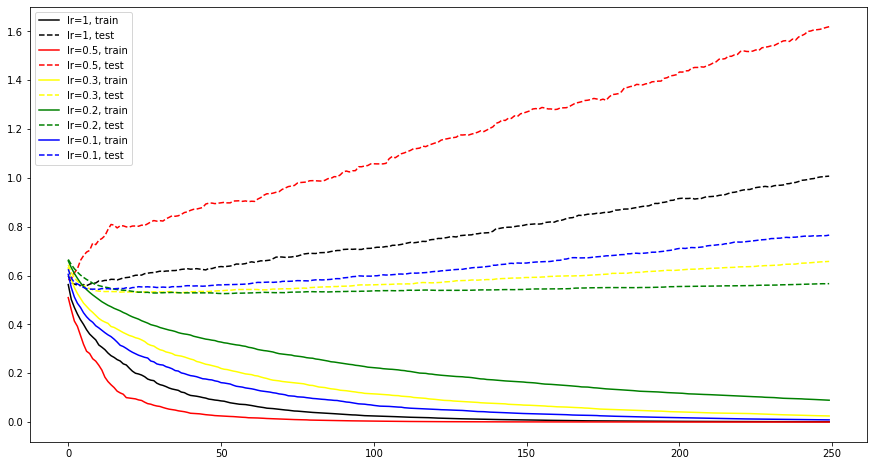

In [6]:
plt.figure(figsize=(15,8))

colors = ['black', 'red', 'yellow', 'green', 'blue']
labels = ['1', '0.5', '0.3', '0.2', '0.1']

for index, values in enumerate(list(zip(losses_train, losses_test))):
    plt.plot(values[0], color=colors[index], label=f'lr={labels[index]}, train')
    plt.plot(values[1], color=colors[index], linestyle='dashed', label=f'lr={labels[index]}, test')
    
plt.legend(loc='upper left')
plt.show()

По графику можно видеть, что хотя на обучающей выборке качество возрастает, на тестовой выборке после примерно 50 итерации качество начинает убывать.

#### 3. Как можно охарактеризовать график качества на тестовой выборке, начиная с некоторой итерации: переобучение (overfitting) или недообучение (underfitting)? В ответе укажите одно из слов overfitting либо underfitting.

In [7]:
write_answer('submission_grad_boosting_1.txt', 'overfitting')

#### 4. Приведите минимальное значение log-loss на тестовой выборке и номер итерации, на котором оно достигается, при learning_rate = 0.2.

In [8]:
%%time

clf = GradientBoostingClassifier(n_estimators=250, learning_rate=0.2, verbose=False, random_state=241)
clf.fit(X_train, y_train)

scores_test = []

for x in clf.staged_decision_function(X_test):
    scores_test.append(log_loss(y_test, [sigmoid(i) for i in x]))

CPU times: user 21.7 s, sys: 16 ms, total: 21.7 s
Wall time: 21.8 s


In [9]:
idx_min = np.argmin(scores_test)
qual_min = scores_test[idx_min]

print(f'Minimum log-loss score = {qual_min} on iteration {idx_min + 1} with lr=0.2')
write_answer('submission_grad_boosting_2.txt', f'{qual_min} {idx_min + 1}')

Minimum log-loss score = 0.5301645204906471 on iteration 37 with lr=0.2


#### 5. На этих же данных обучите RandomForestClassifier с количеством деревьев, равным количеству итераций, на котором достигается наилучшее качество у градиентного бустинга из предыдущего пункта, c random_state=241 и остальными параметрами по умолчанию. Какое значение log-loss на тесте получается у этого случайного леса? (Не забывайте, что предсказания нужно получать с помощью функции predict_proba. В данном случае брать сигмоиду от оценки вероятности класса не нужно)

Если ответом является нецелое число, то целую и дробную часть необходимо разграничивать точкой, например, 0.42. При необходимости округляйте дробную часть до двух знаков.

In [10]:
%%time

clf = RandomForestClassifier(n_estimators=idx_min+1, random_state=241)
clf.fit(X_train, y_train)

predictions = clf.predict_proba(X_test)
loss = log_loss(y_test, predictions)

print(f'Minimum log-loss score = {loss} on Random Forest with {idx_min+1} base trees')
write_answer('submission_grad_boosting_3.txt', loss)

Minimum log-loss score = 0.5410941951182815 on Random Forest with 37 base trees
CPU times: user 308 ms, sys: 30 µs, total: 308 ms
Wall time: 308 ms


Обратите внимание, что, хотя в градиентного бустинге гораздо более слабые базовые алгоритмы, он выигрывает у случайного леса благодаря более "направленной" настройке — каждый следующий алгоритм исправляет ошибки имеющейся композиции. Также он обучается быстрее случайного леса благодаря использованию неглубоких деревьев. В то же время, случайный лес может показать более высокое качество при неограниченных ресурсах — так, он выиграет у градиентного бустинга на наших данных, если увеличить число деревьев до нескольких сотен